In [1]:
import numpy as np
import os
import json
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from GenerateTriplets import GenerateTriplets
from AttributeProcess import process_attributes_csv
from TripletMethod import TripletDataset, QueryDataset
from RetrievalModels import RetrievalModel
from ModelTraining import fine_tune_with_identity, fine_tune_with_attributes
from ImageRetrieval import compute_embedding, retrieve_similar_images, evaluate_test_set
from PlotRetrievedImages import plot_retrieved_images

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
PARENT_DIRNAME = os.path.expanduser("~/image-processing-project/")
IMAGE_DIR = os.path.join(PARENT_DIRNAME, "data/img_align_celeba/")
STORAGE_DATA_DIRNAME = os.path.join(PARENT_DIRNAME, "fine_tuning/data_for_fine_tuning")
MODEL_DIR = os.path.join(PARENT_DIRNAME, "fine_tuning/models")

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = [1, 32, 64]
NUM_EPOCHS = [5, 10, 15]
NUM_WORKERS = 4
LEARNING_RATE = 0.001
TOP_K = 5

In [22]:
train_triplets, test_query_triplets, test_gallery_triplets = GenerateTriplets()

Number of train triplets: 149137
Number of test query triplets: 2027
Number of test gallery triplets: 37482


In [23]:
# save the triplets to a json file
with open(os.path.join(STORAGE_DATA_DIRNAME, "train_triplets.json"), "w") as f:
    json.dump(train_triplets, f)

with open(os.path.join(STORAGE_DATA_DIRNAME, "test_query_triplets.json"), "w") as f:
    json.dump(test_query_triplets, f)

with open(os.path.join(STORAGE_DATA_DIRNAME, "test_gallery_triplets.json"), "w") as f:
    json.dump(test_gallery_triplets, f)

In [24]:
train_attributes = process_attributes_csv()

In [25]:
# save the attributes
with open(os.path.join(STORAGE_DATA_DIRNAME, "train_attributes.json"), "w") as f:
    json.dump(train_attributes, f)

In [26]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [27]:
train_dataset = TripletDataset(
    image_dir=IMAGE_DIR,
    train_triplets=train_triplets,
    attributes=train_attributes,
    transform=image_transforms
)

query_dataset = QueryDataset(
    image_dir=IMAGE_DIR,
    query_triplets=test_query_triplets,
    transform=image_transforms
)

gallery_dataset = QueryDataset(
    image_dir=IMAGE_DIR,
    query_triplets=test_gallery_triplets,
    transform=image_transforms
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE[2], shuffle=True)
query_loader = DataLoader(query_dataset, batch_size=BATCH_SIZE[0], shuffle=False)
gallery_loader = DataLoader(gallery_dataset, batch_size=BATCH_SIZE[1], shuffle=False)

In [28]:
# save the data loaders
torch.save(train_loader, os.path.join(STORAGE_DATA_DIRNAME, "train_loader.pth"))
torch.save(query_loader, os.path.join(STORAGE_DATA_DIRNAME, "query_loader.pth"))
torch.save(gallery_loader, os.path.join(STORAGE_DATA_DIRNAME, "gallery_loader.pth"))

# MobilenetV2

In [5]:
train_loader = torch.load(os.path.join(STORAGE_DATA_DIRNAME, "train_loader.pth"))
query_loader = torch.load(os.path.join(STORAGE_DATA_DIRNAME, "query_loader.pth"))
gallery_loader = torch.load(os.path.join(STORAGE_DATA_DIRNAME, "gallery_loader.pth"))

/tmp/ipykernel_8661/2467728300.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load(os.path.join(STORAGE_DATA_DIRNAME, "train_loader.pth"))
/tmp/ipy

In [6]:
model = RetrievalModel(backbone="mobilenet_v2", embedding_dim=128, num_attributes=40).to(device)

/home/letruongzzio/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/letruongzzio/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

In [11]:
fine_tune_with_identity(
    model=model,
    dataloader=train_loader,
    optimizer=optimizer,
    num_epochs=1,
    device=device,
    num_threads=NUM_WORKERS
)

torch.save(model.state_dict(), os.path.join(MODEL_DIR, "mobilenet_v2_identity.pth"))

Epoch 1/1: 100%|██████████| 2331/2331 [15:16<00:00,  2.54it/s]

Epoch 1, Triplet Loss: 0.3483


In [7]:
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "mobilenet_v2_identity.pth")))

/tmp/ipykernel_8661/1756583994.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "mobilenet_v2_identity.pth")))


<All keys matched successfully>

In [8]:
# Evaluate Precision@K and Recall@K
precision, recall = evaluate_test_set(
    model=model,
    query_loader=query_loader,
    gallery_loader=gallery_loader,
    device=device,
    top_k=TOP_K
)

Computing embeddings for the query set...
Computing embeddings for the gallery set...
Precision@5: 0.0000, Recall@5: 0.0000


In [9]:
# Calculate embedding for query and gallery images
query_embeddings = compute_embedding(model, query_loader, device)
gallery_embeddings = compute_embedding(model, gallery_loader, device)

# Retrieve similar images
retrieved_indices = retrieve_similar_images(
    query_embedding=query_embeddings[0].reshape(1, -1),  # Embedding of the first query image
    gallery_embeddings=gallery_embeddings,
    top_k=TOP_K,
    threshold=0.5
)

print("Retrieved indices:", retrieved_indices)

Retrieved indices: [ 8449 35656 11725 26008  6523]


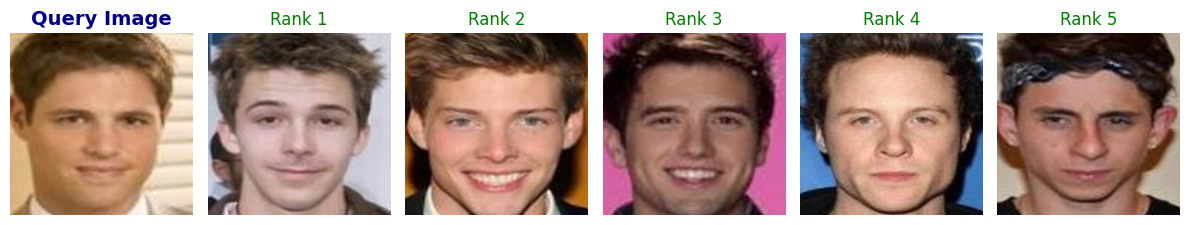

In [ ]:
query_image_path = os.path.join(IMAGE_DIR, query_loader.dataset.query_triplets[0][0])

# Retrieve gallery image paths using valid indices
gallery_image_paths = [
    os.path.join(IMAGE_DIR, gallery_loader.dataset.query_triplets[idx][0]) 
    for idx in retrieved_indices[:5]  # Use top-5 retrieved indices
]

# Plot the query image and retrieved images
plot_retrieved_images(query_image_path, gallery_image_paths, top_k=5)